In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from pyfuncs import *
sns.set_style("darkgrid")

from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from astropy.io import fits
from astropy.table import Table
from IPython.display import display 
from pathlib import Path
import os
import PySimpleGUI as sg
import winsound, cellbell, joblib

c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\pyglet\media\codecs\wmf.py:838: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


# Read and prepare training data
Data is splitted into smaller batches and then standardised

In [2]:
# name of file of training data
filename = 'Test1.fits'

# format name (see astropy.Table documentation for more details)
f = 'fits'

# batch size
bsize = 10000

# number of batches
n = 2

dat = Table.read(filename, format=f)
df = dat.to_pandas()
if (n <= int(len(df)/bsize)) & (n > 0):
    dataset = np.empty(n, dtype=object)
    datasetX = np.empty(n, dtype=object)
    datasetY = np.empty(n, dtype=object)


    for i in range(n):
        dataset[i] = df[(np.array(range(len(df))) % (bnum:=int(len(df)/bsize)) == i) & (df.index < bnum*bsize)]
        dataset[i].reset_index(drop=True,inplace=True)
        datasetX[i] = pd.DataFrame(dataset[i][['dered_u','dered_g','dered_r','dered_i','dered_z']],columns = ['dered_u','dered_g','dered_r','dered_i','dered_z'])
        datasetY[i] = dataset[i]['z']
    print('Dataset has been split into', n, 'batches of', bsize, '.')
else:
    winsound.PlaySound("SystemHand", winsound.SND_ALIAS)
    print('ERROR!! - bsize*n > length of data loaded! Please decrease either n or bsize and try again.')

Dataset has been splitted into 2 batches of 10000 .


# Start training!
The code below will save your predicted data and MLP model in a local save file

In [120]:
%%ding
# change parameters for the regressor model here (see sklearn.mlpregressor documentation for details)
# "hidden layer size" parameter is listed further below as hddlsz 
mlp = MLPRegressor(activation='relu', solver='adam',batch_size='auto', random_state = 33)

# tperc is the percentage of data used for training (input should be a float between 0 and 1) 
# the rest is use for testing
tperc = 0.7

# number of random states used
rdnum = 1

# which predicted data file to read from (if file doesn't exist or left blank, a blank DataFrame is created instead)
# even if left blank, '' must be present
fread = 'Test1Results/NewData(relu,adam).json'

# which file to write to (if file doesn't exist, a file with same name will be created)
# DO NOT FORGET THE FILENAME EXTENSION ".json"!!
fwrite = 'Test1Results/NewData(relu,adam).json'

# name of folder to save all MLP models
mlpfolder = 'MLP_models_and_scalers1'

# list of hidden layer sizes. Each hidden layer size should be in the data type "tuple".
# multiple hidden layer sizes can be put together in a List so that the code runs through all of them
# i.e. [(1,1,1),(2,2),...]; for a single tuple, write [(20,20,20)]
hddlsz = [(10,10,10,10),(25,10,5),(50,50,50),(50,50,50,50),(100,100,100,100),(200,200,200)]
#[(100,100,100),(100,100),(100),(50,50,50),(50,50),(50),(25,25,25),(25,25),(25),(10,10,10),(10,10),(10),(5,5,5),(5,5),(5)]


randst = mlp.random_state
try:
    mdata = pd.read_json(fwrite) 
except:
    event = 'Proceed'
else:
    if fread == fwrite:
        winsound.PlaySound("SystemHand", winsound.SND_ALIAS)
        event, values = sg.Window('WARNING',
                      [[sg.T('WARNING - fread = fwrite! Proceeding will add current data to ' + fread + '!')],
                      [sg.B('Proceed'), sg.B('Cancel') ]]).read(close=True)
    else:
        winsound.PlaySound("SystemHand", winsound.SND_ALIAS)
        event, values = sg.Window('WARNING',
                      [[sg.T('WARNING - ' + fwrite + ' already exist! Proceeding will overwrite the data in ' + fwrite + '!')],
                      [sg.B('Proceed'), sg.B('Cancel') ]]).read(close=True)

if (Path('Saved_models_and _scalers/' + mlpfolder).is_dir() == True) & (event == 'Proceed'):
    winsound.PlaySound("SystemHand", winsound.SND_ALIAS)
    event1, values1 = sg.Window('WARNING',
                      [[sg.T('WARNING - ' + mlpfolder + ' already exist! Proceeding might overwrite all the files in ' + mlpfolder + '!')],
                      [sg.B('Proceed'), sg.B('Cancel') ]]).read(close=True)
else: 
    event1 = 'Proceed'
        
try:
    mdata = pd.read_json(fread)
except:
    mdata = pd.DataFrame()

if (event == 'Proceed') & (event1 == 'Proceed'):   
    lenX = len(datasetX)
    if (Path('Saved_models_and _scalers').is_dir() == True):
        pass
    else: 
        os.mkdir('Saved_models_and _scalers', mode=0o666)
    if Path('Saved_models_and _scalers/' + mlpfolder).is_dir() == True:
        pass
    else:
        os.mkdir('Saved_models_and _scalers/' + mlpfolder, mode=0o666)
    for x in hddlsz:
        mlp.hidden_layer_sizes = x
        for i in range(lenX):   
            scaler = StandardScaler()
            trainX, testX, trainY, testY = train_test_split(datasetX[i], datasetY[i],random_state=1, test_size=1-tperc)
            trainX = scaler.fit_transform(trainX)
            testX = scaler.transform(testX)
            filename = 'Saved_models_and _scalers/' + mlpfolder + '/' + 'Scaler-' + str(mlp.hidden_layer_sizes) + ','\
            + mlp.solver + ','+ mlp.activation + ',' + 'dataset' + str(i) + '.pkl'
            joblib.dump(scaler, filename)
            score = np.empty(rdnum,dtype=object)
            loss = np.empty(rdnum,dtype=object)
            ypredict = np.empty(rdnum,dtype=object)
            for k in range(rdnum):
                mlp.random_state = randst + k
                regr = mlp.fit(trainX,trainY)
                loss[k] = regr.loss_
                filename = 'Saved_models_and _scalers/' + mlpfolder + '/' + 'MLP-' + str(mlp.hidden_layer_sizes) + ','\
                + mlp.solver + ','+ mlp.activation + ',' + 'dataset' + str(i) + ', random_state' + str(mlp.random_state) + '.pkl'
                joblib.dump(regr, filename)
                score[k] = regr.score(testX,testY)
                ypredict[k] = regr.predict(testX)


            loss = loss[:,np.newaxis]
            score = score[:,np.newaxis]
            ypredict = ypredict[:,np.newaxis]
            comb = np.concatenate((score,loss,ypredict),axis=1)
            comb = pd.DataFrame(data = comb, columns = ['Score','Loss','ypredict'])
            comb['Hidden layer size'] = [mlp.hidden_layer_sizes]*rdnum
            comb['Random state'] = list(range(randst,mlp.random_state + 1))
            comb['Training data'] = ['dataset ' + str(i)]*rdnum
            comb['ytest data'] = [list(testY)]*rdnum
            mdata = mdata.append(comb, ignore_index = True)

    pd.DataFrame(mdata).to_json(fwrite)
    display(mdata)
else:
    print('Process has been stopped.')

,Score,Loss,ypredict,Hidden layer size,Random state,Training data,ytest data
0,0.517078,0.000662,"[0.1532913471, 0.0671873174, 0.1391760882, 0.1...","[10, 10, 10]",33,dataset 0,"[0.27149629999999997, 0.08508018, 0.1019322, 0..."
1,0.523123,0.000646,"[0.2271622708, 0.039125120400000005, 0.0933669...","[10, 10, 10]",33,dataset 1,"[0.2714972, 0.08508024, 0.1019326, 0.08553334,..."
2,0.789514,0.000359,"[0.1721215748, 0.0638247684, 0.0786761259, 0.1...","[100, 100, 100]",33,dataset 0,"[0.27149629999999997, 0.08508018, 0.1019322, 0..."
3,0.781916,0.000337,"[0.2779143804, 0.1367556124, 0.108657425100000...","[100, 100, 100]",33,dataset 1,"[0.2714972, 0.08508024, 0.1019326, 0.08553334,..."
4,0.513106,0.000725,"[0.13330205480975044, 0.08061443420817777, 0.0...","(10, 10, 10, 10)",33,dataset 0,"[0.2714963, 0.08508018, 0.1019322, 0.08553326,..."
5,0.481005,0.000738,"[0.20253128085701125, 0.14941399749982032, 0.1...","(10, 10, 10, 10)",33,dataset 1,"[0.2714972, 0.08508024, 0.1019326, 0.08553334,..."
6,0.546375,0.000615,"[0.13585878825308217, 0.07709289633203376, 0.0...","(25, 10, 5)",33,dataset 0,"[0.2714963, 0.08508018, 0.1019322, 0.08553326,..."
7,0.568411,0.000668,"[0.2320424605963617, 0.07612184679001943, 0.11...","(25, 10, 5)",33,dataset 1,"[0.2714972, 0.08508024, 0.1019326, 0.08553334,..."
8,0.783104,0.000329,"[0.1799931590300786, 0.0771030559264549, 0.088...","(50, 50, 50)",33,dataset 0,"[0.2714963, 0.08508018, 0.1019322, 0.08553326,..."
9,0.791434,0.000329,"[0.23823187599356524, 0.11337438271986487, 0.1...","(50, 50, 50)",33,dataset 1,"[0.2714972, 0.08508024, 0.1019326, 0.08553334,..."


# Read file (.json file that is generated by the MLP above)

In [3]:
# name/path of file that will be read 
fread = 'Test1Results/NewData(relu,adam).json'

mdata = pd.read_json(fread)

# Mean score (coefficient of determination) of each hidden layer size configuration

In [7]:
a = sortHLS(mdata)
num = len(a)
Mean = pd.DataFrame()
for n in range(num):
    try:
        scr = list(mdata['Score'].loc[a[n]].mean())
        hls = list(mdata['Hidden layer size'].loc[a[n][0]])
    except:
        scr = [mdata['Score'].loc[a[n]].mean()]
        hls = [mdata['Hidden layer size'].loc[a[n][0]]]
    comb = pd.DataFrame({'Score':scr,'Hidden layer size':hls})
    Mean = Mean.append(comb,ignore_index=True)
display(Mean.sort_values(by=['Score'],ascending=False))

,Score,Hidden layer size
6,0.792221,"[100, 100, 100, 100]"
4,0.787269,"[50, 50, 50]"
1,0.785715,"[100, 100, 100]"
7,0.770657,"[200, 200, 200]"
5,0.769954,"[50, 50, 50, 50]"
3,0.557393,"[25, 10, 5]"
0,0.520101,"[10, 10, 10]"
2,0.497056,"[10, 10, 10, 10]"


# Plot graph of predicted data VS sample data 

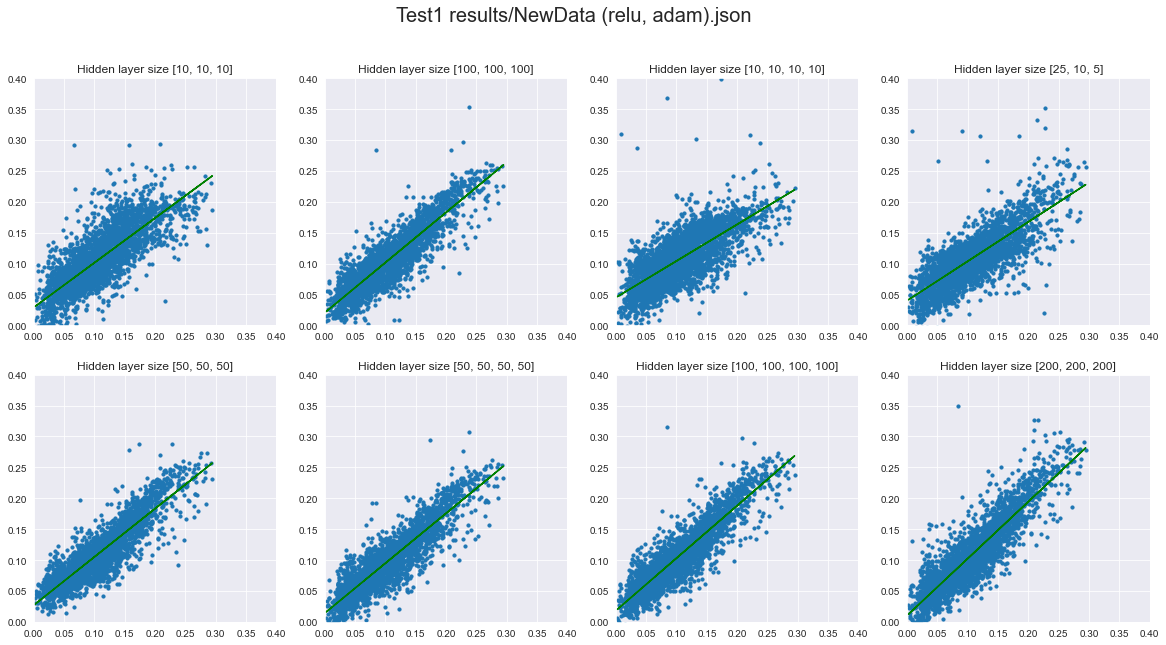

In [10]:
# size of subplot (number of rows and columns must always be greater than 1)
row = 2
column = 4

# random state of mlp
rdst = 33

# training dataset of mlp
Tdata = 0

fig, ax = plt.subplots(row,column, figsize = (20,10))
fig.suptitle(fread, fontsize = 20)
n = 0
a = sortHLS(mdata)
num = len(a) 
crit = mdata[(mdata['Random state'] == rdst) & (mdata['Training data'] == ('dataset ' + str(Tdata)))] 
indx = crit.index

for i in range(row):
    for j in range(column):
        if n < num:
            ax[i,j].scatter(crit.loc[indx[n], 'ytest data'], crit.loc[indx[n], 'ypredict'], s = 10)
            m, b = np.polyfit(crit.loc[indx[n], 'ytest data'], crit.loc[indx[n], 'ypredict'], 1)
            ax[i,j].plot(crit.loc[indx[n], 'ytest data'], m * np.array(crit.loc[indx[n], 'ytest data']) + b, color = 'green')
            title = 'Hidden layer size ' + str(mdata['Hidden layer size'].loc[indx[n]])
            ax[i,j].set_title(title)
            ax[i,j].set_xlim(0,0.4)
            ax[i,j].set_ylim(0,0.4)
            n = n + 1
            
plt.show()

# Load model and scaler

In [4]:
ldmodel = joblib.load('Saved_models_and _scalers/MLP models and scalers 1/MLP - (100, 100, 100, 100), adam, relu, dataset 0, random state 33.pkl')
ldscaler = joblib.load('Saved_models_and _scalers/MLP models and scalers 1/Scaler - (100, 100, 100, 100), adam, relu, dataset 0.pkl')

# Test loaded model

0.7967482579386416


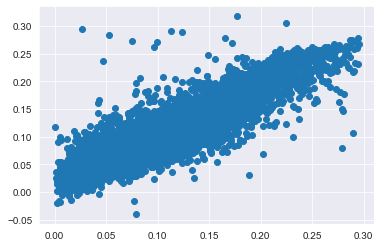

In [9]:
# read test data
tdataX = datasetX[1]

testX = ldscaler.transform(tdataX)
ypredict = ldmodel.predict(testX)
print(ldmodel.score(testX,datasetY[1]))
plt.scatter(datasetY[1],ypredict)